In [1]:
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#loading the raw fimo output to a dataframe
df = pd.read_csv("fimo.tsv",delimiter='\t')

In [3]:
#defining function to find overlapping regions
def find_overlapping_intervals(start_pos, end_pos):
    if len(start_pos) == 0:
        return []
    
    # Create DataFrame from the input lists
    intervals = pd.DataFrame({
        'Start': start_pos,
        'End': end_pos
    })
    
    # Sort intervals by start position
    intervals = intervals.sort_values(by='Start').reset_index(drop=True)
    
    results = []
    current_start = intervals.loc[0, 'Start']
    current_end = intervals.loc[0, 'End']
    
    for i in range(1, len(intervals)):
        next_start = intervals.loc[i, 'Start']
        next_end = intervals.loc[i, 'End']
        
        if next_start <= current_end:
            # Extend the current interval
            current_end = max(current_end, next_end)
        else:
            # Record the non-overlapping interval
            results.append((current_start, current_end))
            current_start = next_start
            current_end = next_end
    
    # Append the last interval
    results.append((current_start, current_end))
    
    return results

In [4]:
# Initialize output list
output = []

# Loop through each unique gene-TF-strand combination
for (gene, tf, strand), subset_df in df.groupby(['sequence_name', 'motif_alt_id', 'strand']):
    start_positions = subset_df['start'].tolist()
    end_positions = subset_df['stop'].tolist()
    
    # Find overlapping intervals
    overlapping_intervals = find_overlapping_intervals(start_positions, end_positions)
    
    # Add results to output
    for start, end in overlapping_intervals:
        output.append([gene, tf, start, end])

# Convert to DataFrame
output_df = pd.DataFrame(output, columns=['Gene', 'TF', 'Start', 'End'])

# Output to .tsv and .xlsx files
output_df.to_csv('fimo_consolidated_ss.tsv', sep='\t', index=False)

In [5]:
#contingency table
df_play = pd.read_csv('fimo_consolidated_ss.tsv',delimiter='\t')
df_play.fillna('NA',inplace=True)
cont_table_fimo = pd.crosstab(df_play['Gene'],df_play['TF'])#, margins=True)
cont_table_fimo.to_csv('contingency_fimo.tsv',sep='\t')

In [6]:
#mapping CUB data to the contingency table
# Load the contingency table file
cont_table_fimo = pd.read_csv('contingency_fimo.tsv', sep='\t')

# Load the .xlsx file containing CAI and Nc data, but only select the 'Name', 'CAI', and 'Nc' columns
cai_nc_data = pd.read_excel('CUBIndices.xlsx', usecols=['Name', 'CAI', 'Nc'])

# Merge both files based on the gene ids
# Assuming 'Gene' is the common column in the .tsv file and 'Name' in the .xlsx file
merged_data = pd.merge(cont_table_fimo, cai_nc_data, left_on='Gene', right_on='Name')

# Drop the 'Name' column from the final result (keeping only 'Gene')
merged_data = merged_data.drop(columns=['Name'])

# Save the final merged data into a new .tsv file
merged_data.to_csv('contingency_fimo_cub.tsv', sep='\t', index=False)

print("Merging completed. Final data saved to 'contingency_fimo_cub.tsv'.")


Merging completed. Final data saved to 'contingency_fimo_cub.tsv'.


In [16]:
# Load the final TSV file
data = pd.read_csv('contingency_fimo_cub.tsv', sep='\t')

# Select only TF columns by excluding 'Gene', 'CAI', and 'Nc'
tf_columns = data.drop(columns=['Gene', 'CAI', 'Nc']).columns

# Function to calculate and return significant Spearman correlations (p < 0.05)
def find_significant_correlations(target):
    significant_results = {}
    for tf in tf_columns:
        r_value, p_value = spearmanr(data[tf], data[target], nan_policy='omit')
        if p_value < 0.05:  # Check for significance
            significant_results[tf] = {'R_value': r_value, 'P_value': p_value}
    return significant_results

# Get significant correlations for both CAI and Nc
significant_cai = find_significant_correlations('CAI')
significant_nc = find_significant_correlations('Nc')

# Combine all significant results into one DataFrame
all_significant_results = []
for tf in set(significant_cai.keys()).union(significant_nc.keys()):
    all_significant_results.append({
        'TF': tf,
        'CAI_R_value': significant_cai.get(tf, {}).get('R_value', None),
        'CAI_P_value': significant_cai.get(tf, {}).get('P_value', None),
        'Nc_R_value': significant_nc.get(tf, {}).get('R_value', None),
        'Nc_P_value': significant_nc.get(tf, {}).get('P_value', None)
    })
all_results_df = pd.DataFrame(all_significant_results)

# Filter to get only TFs significant with both CAI and Nc
common_tfs = set(significant_cai.keys()).intersection(set(significant_nc.keys()))
common_results = [row for row in all_significant_results if row['TF'] in common_tfs]
common_results_df = pd.DataFrame(common_results)

# Save both results to .tsv and .xlsx files
all_results_df.to_csv('tfbs_cub_corr_all_output.tsv', sep='\t', index=False)
all_results_df.to_excel('tfbs_cub_corr_all_output.xlsx', index=False)

common_results_df.to_csv('tfbs_cub_corr_common_output.tsv', sep='\t', index=False)
common_results_df.to_excel('tfbs_cub_corr_common_output.xlsx', index=False)

print("All significant results saved to 'tfbs_cub_corr_all_output.tsv' and 'tfbs_cub_corr_all_output.xlsx'.")
print("Common significant results saved to 'tfbs_cub_corr_common_output.tsv' and 'tfbs_cub_corr_common_output.xlsx'.")


All significant results saved to 'tfbs_cub_corr_all_output.tsv' and 'tfbs_cub_corr_all_output.xlsx'.
Common significant results saved to 'tfbs_cub_corr_common_output.tsv' and 'tfbs_cub_corr_common_output.xlsx'.


In [17]:
#extracting TFs based on significance
# Combine all significant TFs (either CAI or Nc)
all_significant_tfs = set(significant_cai).union(significant_nc)

# Find TFs that are significant in both CAI and Nc
common_significant_tfs = set(significant_cai).intersection(significant_nc)

# Filter the original data for significant TFs + 'Gene', 'CAI', and 'Nc'
all_significant_data = data[['Gene', 'CAI', 'Nc'] + list(all_significant_tfs)]
common_significant_data = data[['Gene', 'CAI', 'Nc'] + list(common_significant_tfs)]
# Filter the original data for significant TFs + 'Gene', 'CAI', and 'Nc'
all_significant_data = data[['Gene', 'CAI', 'Nc'] + list(all_significant_tfs)]
common_significant_data = data[['Gene', 'CAI', 'Nc'] + list(common_significant_tfs)]

# Save the filtered data to .tsv and .xlsx files
all_significant_data.to_csv('tfbs_cub_all_significant_output.tsv', sep='\t', index=False)
all_significant_data.to_excel('tfbs_cub_all_significant_output.xlsx', index=False)

common_significant_data.to_csv('tfbs_cub_common_significant_output.tsv', sep='\t', index=False)
common_significant_data.to_excel('tfbs_cub_common_significant_output.xlsx', index=False)

print("All significant TFs saved to 'tfbs_cub_all_significant_output.tsv' and 'tfbs_cub_all_significant_output.xlsx'.")
print("Common significant TFs saved to 'tfbs_cub_common_significant_output.tsv' and 'tfbs_cub_common_significant_output.xlsx'.")

All significant TFs saved to 'tfbs_cub_all_significant_output.tsv' and 'tfbs_cub_all_significant_output.xlsx'.
Common significant TFs saved to 'tfbs_cub_common_significant_output.tsv' and 'tfbs_cub_common_significant_output.xlsx'.


<Figure size 800x600 with 0 Axes>

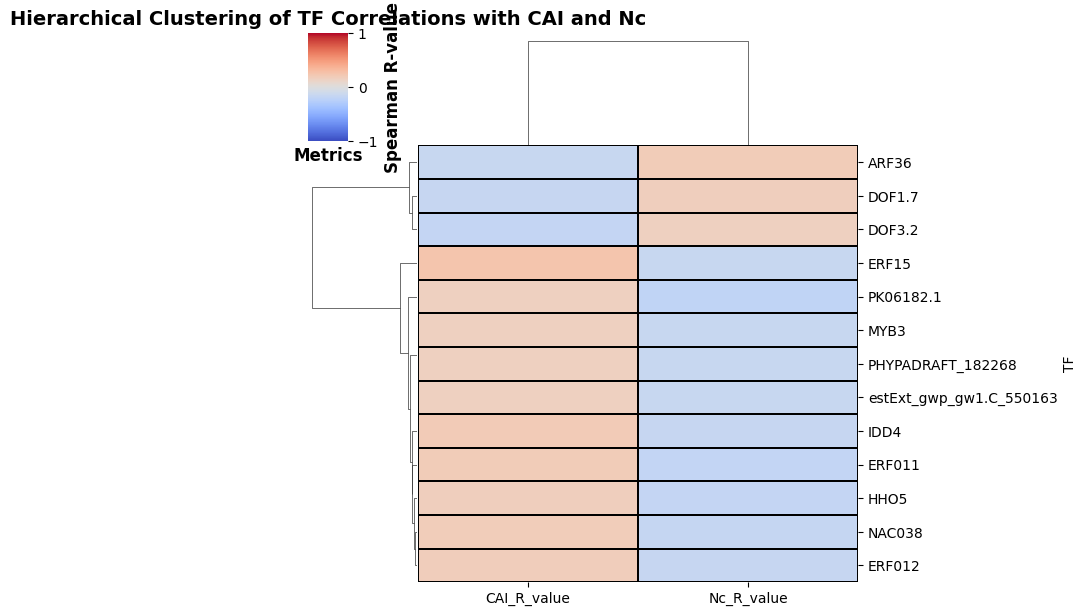

In [10]:
#Output CI values

# Function to calculate Fisher transformation and confidence interval
def fisher_confidence_interval(r_value, n, confidence_level=0.95):
    if abs(r_value) == 1:
        return r_value, r_value  # Perfect correlation, no variance in CI
    z = 0.5 * np.log((1 + r_value) / (1 - r_value))
    z_critical = norm.ppf(1 - (1 - confidence_level) / 2)
    se = 1 / np.sqrt(n - 3)
    z_interval = z_critical * se
    z_lower, z_upper = z - z_interval, z + z_interval
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    return r_lower, r_upper

# Load the final TSV file
data = pd.read_csv('contingency_fimo_cub.tsv', sep='\t')

# Select only TF columns by excluding 'Gene', 'CAI', and 'Nc'
tf_columns = data.drop(columns=['Gene', 'CAI', 'Nc']).columns

# Function to calculate and return significant Spearman correlations (p < 0.05)
def find_significant_correlations(target):
    significant_results = {}
    for tf in tf_columns:
        r_value, p_value = spearmanr(data[tf], data[target], nan_policy='omit')
        n = data[tf].notnull().sum()  # Sample size (excluding NaNs)
        if p_value < 0.05:  # Check for significance
            ci_lower, ci_upper = fisher_confidence_interval(r_value, n)
            significant_results[tf] = {
                'R_value': r_value,
                'P_value': p_value,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            }
    return significant_results

# Get significant correlations for both CAI and Nc
significant_cai = find_significant_correlations('CAI')
significant_nc = find_significant_correlations('Nc')

# Find TFs that are significant in both CAI and Nc
common_tfs = set(significant_cai.keys()).intersection(set(significant_nc.keys()))

# Create a DataFrame to hold the results
results = []
for tf in common_tfs:
    results.append({
        'TF': tf,
        'CAI_R_value': significant_cai[tf]['R_value'],
        'CAI_CI_lower': significant_cai[tf]['CI_lower'],
        'CAI_CI_upper': significant_cai[tf]['CI_upper'],
        'Nc_R_value': significant_nc[tf]['R_value'],
        'Nc_CI_lower': significant_nc[tf]['CI_lower'],
        'Nc_CI_upper': significant_nc[tf]['CI_upper'],
    })

results_df = pd.DataFrame(results)

# Save the results to a .tsv file
results_df.to_csv('tfbs_cub_corr_common_output_with_CI.tsv', sep='\t', index=False)

# Save the results to an Excel file
results_df.to_excel('tfbs_cub_corr_common_output_with_CI.xlsx', index=False)

# Plot a clustermap of the R_values with hierarchical clustering
heatmap_data = results_df.set_index('TF')[['CAI_R_value', 'Nc_R_value']]

# Create a clustermap with streamlined design
plt.figure(figsize=(8, 6))
clustermap = sns.clustermap(
    heatmap_data, 
    annot=False,  # Remove annotations
    cmap='coolwarm', 
    center=0, 
    cbar_kws={'label': 'Spearman R-value'},
    figsize=(8, 6),
    linewidths=0.3,  # Thin lines for cell separation
    linecolor='black',
    vmin=-1, vmax=1
)

# Adjust title and labels
plt.title('Hierarchical Clustering of TF Correlations with CAI and Nc', fontsize=14, weight='bold')
plt.xlabel('Metrics', fontsize=12, weight='bold')
plt.ylabel('Transcription Factors', fontsize=12, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
clustermap.cax.set_ylabel('Spearman R-value', fontsize=12, weight='bold')

# Show plot
plt.show()
